# ATP Data Exploratory Data Analysis

https://www.kaggle.com/sijovm/atpdata


## Data description
* tourney_id - tournament_id
* tourney_name - tournament_name
* surface - surface in which the match is played
* draw_size - the size of the draw
* tourney_level - tournament level
    * 'G' = Grand Slams
    * 'M' = Masters 1000s
    * 'A' = other tour-level events
    * 'C' = Challengers
    * 'S' = Satellites/ITFs
    * 'F' = Tour finals and other season-ending events
    * 'D' = Davis Cup
* tourney_date - starting date of the tournament
* match num - match number in a certain tournament
* id - player id
* seed - the seed of the player in that tournament
* entry - How did the player enter the tournaments?
    * WC - Wildcard
    * Q - Qualifier
    * LL - Lucky loser
    * PR - Protected ranking
    * SE - Special Exempt
    * ALT - Alternate player
* name - player name
* hand - hand of the player, right or left
* ht - the height of the player
* IOC - the country of origin
* age - age of the player
* score - final score in the match
* best_of - the maximum number of sets played
* round - the round in the tournament a match belongs to
* minutes - duration of the match in minutes
* ace - number of aces in the match 
* df - double faults
* svpt - serve percent
* 1stin - first serve in percent
* 1stWon - first serve winning percent
* 2ndWon - second serve winning percent
* SvGms - number of games played on serve (So, the maximum difference between w_SvGms and l_SvGms will be 1)
* bpSaved - breakpoints saved
* bpFaced - breakpoints faced
Credits: 1) http://www.tennisabstract.com/ 2) Jeff Sackmann
NOTE: The rankings are available in the other CSVs

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()



In [2]:
# dataset is separated by year - each year has it's own separate csv file
# we will have to append together all data into one data frame
DATASET_DIR = '../datasets'
START_YEAR = 1985
END_YEAR = 2019
OUTFILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_preprocessed.csv'
years = np.arange(START_YEAR, END_YEAR + 1)

matches_all = pd.DataFrame()
for year in years:
    matches_all = matches_all.append(pd.read_csv(f'{DATASET_DIR}/tennis_atp-master/atp_matches_{year}.csv', parse_dates=["tourney_date"]), ignore_index=True)


In [3]:
matches_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113991 entries, 0 to 113990
Data columns (total 49 columns):
tourney_id            113991 non-null object
tourney_name          113991 non-null object
surface               113873 non-null object
draw_size             0 non-null float64
tourney_level         113991 non-null object
tourney_date          113991 non-null datetime64[ns]
match_num             113991 non-null int64
winner_id             113991 non-null int64
winner_seed           46264 non-null float64
winner_entry          13105 non-null object
winner_name           113991 non-null object
winner_hand           113973 non-null object
winner_ht             108216 non-null float64
winner_ioc            113991 non-null object
winner_age            113710 non-null float64
loser_id              113991 non-null int64
loser_seed            24766 non-null float64
loser_entry           22139 non-null object
loser_name            113991 non-null object
loser_hand            113948 non-

## draw size

It looks like we don't have draw size past 1968 from this dataset, however, we can impute this data from the number of unique players for a particular tournament

In [4]:
matches_all[matches_all.draw_size.notnull()][["tourney_id", "tourney_name", "tourney_level", "tourney_date", "draw_size"]].tourney_date.max()

NaT

## How much data do we have?

C, S, D are generally not what you see on TV. They are tournaments that are a levels below the tournaments - we will filter those

We are also going to split the dataset into 2:
* first one will have all data
* second will only have matches from 1998 on. Why 1998? That is the year that Federer turned pro - I generally consider this a new era of tennis



In [5]:
# exclude other tour-level events, challengers and satellites, and Davis Cup
matches = matches_all[~matches_all.tourney_level.isin(["C", "S", "D"])]
# federer turned pro in 1998 - we will exclude all data before then
matches98 = matches[matches.tourney_date > datetime.datetime(1998, 1, 1)]

In [6]:
matches.tourney_date.min()

Timestamp('1985-01-07 00:00:00')

In [7]:
len(matches)

103579

In [8]:
matches98.tourney_date.min()

Timestamp('1998-01-05 00:00:00')

In [9]:
len(matches98)

59764

In [10]:
matches.tourney_date.max()

Timestamp('2019-02-25 00:00:00')

### Player entry

Entry is supposed to tell you how the player made it into the tournament. We are missing this information for most player.
Looking at the data, it's pretty random:
* we have players that are ranked and seeding
* players that are not seeding but having pretty high rank (ie, < 50)
* players that have lower randkings (ie, > 100)

There is also 'S' in the loser entry which is not explained in the dataset

We should drop this column, since we don't have enough information to impute

In [11]:
print(matches.loser_entry.unique())
print(matches.winner_entry.unique())
print(matches[matches.loser_entry.isnull()].sample(10)[["loser_name", "loser_rank", "loser_seed"]])
print(matches[matches.winner_entry.isnull()].sample(10)[["winner_name", "winner_rank", "winner_seed"]])

[nan 'Q' 'WC' 'LL' 'PR' 'S' 'SE' 'ALT']
[nan 'Q' 'WC' 'LL' 'PR' 'SE' 'ALT']
              loser_name  loser_rank  loser_seed
86648      Frederico Gil        70.0         NaN
26531     Omar Camporese        29.0         NaN
46171   Jeff Salzenstein       146.0         NaN
54123   Franco Squillari        47.0         NaN
10360      Stefan Edberg         2.0         2.0
106652    Kevin Anderson        33.0         9.0
8104     Ricki Osterthun        82.0         NaN
73130     Olivier Rochus        33.0         8.0
14275       Andre Agassi         3.0         1.0
8144          Matt Anger        66.0         NaN
              winner_name  winner_rank  winner_seed
12010     Richey Reneberg         76.0         12.0
78808   Nikolay Davydenko          4.0          4.0
5443      Jonathan Canter         61.0          NaN
25687        German Lopez         79.0          4.0
23446       Amos Mansdorf         53.0         16.0
36298          Petr Korda         20.0          NaN
67676         Taylor 

In [12]:
# drop these columns
matches = matches.drop(["draw_size","loser_entry", "winner_entry", "loser_seed", "winner_seed"], axis=1)

In [13]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103579 entries, 0 to 113990
Data columns (total 44 columns):
tourney_id            103579 non-null object
tourney_name          103579 non-null object
surface               103579 non-null object
tourney_level         103579 non-null object
tourney_date          103579 non-null datetime64[ns]
match_num             103579 non-null int64
winner_id             103579 non-null int64
winner_name           103579 non-null object
winner_hand           103579 non-null object
winner_ht             101252 non-null float64
winner_ioc            103579 non-null object
winner_age            103562 non-null float64
loser_id              103579 non-null int64
loser_name            103579 non-null object
loser_hand            103579 non-null object
loser_ht              99172 non-null float64
loser_ioc             103579 non-null object
loser_age             103418 non-null float64
score                 103575 non-null object
best_of               1035

# Summary of missing data
* From 1972 to 1997, there were 43815 matches. From 1998 to 2/2019, there were 59764 matches.
* most matches are missing player entry - winners are missing more entries than losers. will have to drop this - this might be an important statistic as qualifiers have to play more matches to get into the tournament - we should look at why we are missing this data.
* only a subset of players have seeds which makes sense. For a tournament only the top players receive a seed. Seeds are determined by the player's rank, the rest of the players are considered unseeded - we can impute this based on the player's ranking during the tournament
* player height - we seem to be missing some - we can probably just impute this with average height from that column 
* draw size - we are missing draw size for tournaments after 1968 - we can impute this by looking at how many unique players were there in a given tournament

## Missing Match Stats

* looks like when we are missing data for matches (~600), when we are missing one stat, the rest are missing

In [14]:
matches[matches.l_1stIn.isnull()].sample(10).T

,9434,6608,13602,19430,4557,13368,13647,2042,18672,54149
tourney_id,1987-423,1986-240,1988-429,1990-741,1986-520,1988-330,1988-303,1985-319,1990-410,1999-604
tourney_name,Los Angeles,Itaparica,Stockholm,Manchester,Roland Garros,Tel Aviv,Buenos Aires,Kitzbuhel,Monte Carlo Masters,Grand Slam Cup
surface,Hard,Hard,Hard,Grass,Clay,Hard,Clay,Clay,Clay,Hard
tourney_level,A,A,A,A,G,A,A,A,M,A
tourney_date,1987-09-21 00:00:00,1986-11-24 00:00:00,1988-10-31 00:00:00,1990-06-18 00:00:00,1986-05-26 00:00:00,1988-10-10 00:00:00,1988-11-07 00:00:00,1985-08-05 00:00:00,1990-04-23 00:00:00,1999-09-27 00:00:00
match_num,5,26,23,28,23,6,13,28,6,8
winner_id,101096,100548,101723,101948,100990,100950,101439,100951,101404,102257
winner_name,Gary Muller,Ivan Kley,Magnus Larsson,Pete Sampras,Milan Srejber,Libor Pimek,Javier Sanchez,Alessandro De Minicis,Thomas Muster,Greg Rusedski
winner_hand,L,R,R,R,R,R,R,R,L,L
winner_ht,190,183,193,185,203,196,178,175,180,193


## Let's see if the tournament has anything to do with the missing stats

To see if there are any tournaments with no stats at all, we add up the stats column - if it's 0 then there means there wer not stats at all

Looks like there are only 4 tournaments where we are completely missing stats

In [15]:
match_stats = matches.groupby("tourney_id").sum()
match_stats[match_stats.l_1stIn == 0]

,match_num,winner_id,winner_ht,winner_age,loser_id,loser_ht,loser_age,best_of,minutes,w_ace,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
tourney_id,,,,,,,,,,,,,,,,,,,,,
1984-605,66,1107169,1998.0,278.03,1107940,2014.0,272.92,35,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,100.0,0.0
1985-301,496,3120825,5669.0,774.69,3128766,5314.0,737.87,95,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3904.0,0.0,6971.0,0.0
1985-302,496,3117932,5732.0,821.93,3120965,5763.0,777.30,93,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1579.0,0.0,3035.0,0.0
1985-303,496,3129289,5566.0,681.16,3139589,5277.0,660.39,93,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3869.0,0.0,5841.0,0.0
1985-304,496,3122538,5724.0,757.32,3122979,5687.0,756.95,93,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4405.0,0.0,4651.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997-604,120,1530333,2797.0,385.24,1529610,2788.0,392.10,51,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,112.0,44158.0,234.0,29992.0
1998-604,66,1125372,2000.0,275.10,1123948,2043.0,283.91,39,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,94.0,29235.0,183.0,22326.0
1999-604,66,1128150,2103.0,270.22,1127160,2061.0,276.45,39,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,131.0,22674.0,160.0,24435.0


There are 150 matches in the 4 tournaments that are missing stats, which means there are 450 more from other tournaments

In [16]:
tids = [tid for _, tid in match_stats[match_stats.l_1stIn == 0].reset_index().tourney_id.items()]
print(len(tids))
len(matches[matches.tourney_id.isin(tids)])

474


19994

In [17]:
missing_matches = matches[(matches.l_1stIn.isnull()) & (~matches.tourney_id.isin(tids))]
# number of tournaments that are missing matches
len(missing_matches.tourney_id.unique())

502

Most tournaments are only missing a stats for a few matches

In [18]:
missing_matches.tourney_id.value_counts()

1991-520    80
1993-560    25
1994-540    20
1997-348    17
1996-540    16
            ..
1997-321     1
1997-424     1
2012-560     1
1993-224     1
1994-773     1
Name: tourney_id, Length: 502, dtype: int64

In [19]:
missing_matches["round"].value_counts()

R32     264
R16     230
R128    151
QF      112
R64      88
SF       44
F        19
RR       14
BR        2
Name: round, dtype: int64

## Other Missing Data

* missing height - let's impute this with the average for that column
* minutes (match length) - let's impute this with average match time for each tournament

In [20]:
len(matches[(matches.loser_ht.isnull()) | (matches.winner_ht.isnull())])

6018

In [21]:
# let's figure out specifically how many players are we missing ht
matches.loc[:, "loser_name"] = matches.loser_name.apply(lambda x: x.strip().lower())
matches.loc[:, "winner_name"] = matches.winner_name.apply(lambda x: x.strip().lower())


//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Player Heights')

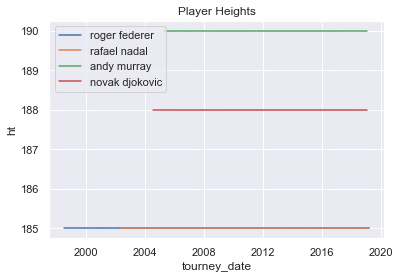

In [22]:
# let's take a closer look at player height and see if it changes over time - we will look at the big 4

def plot_player_height(player: str):
    rf_loser = matches[(matches.loser_name == player)][["tourney_date", "loser_name", "loser_ht"]].rename({"loser_name": "name", "loser_ht": "ht"}, axis=1)
    rf_winner = matches[(matches.winner_name == player)][["tourney_date", "winner_name", "winner_ht"]].rename({"winner_name": "name", "winner_ht": "ht"}, axis=1)
    player_history = rf_loser.append(rf_winner).sort_values("tourney_date")

    sns.lineplot(x=player_history.tourney_date, y=player_history.ht, label=player)
    
    
players = ["roger federer", "rafael nadal", "andy murray", "novak djokovic"]
for player in players:
    plot_player_height(player)
plt.title("Player Heights")

## Let's figure out how many players we have

There is a total of 2503 players in our data set. All of which have lost at least 1 match

In [33]:
losers = matches[["loser_id", "loser_name", "loser_ht", "loser_hand", "loser_ioc"]].drop_duplicates(subset="loser_name", keep="last").sort_values("loser_name").\
    rename({"loser_id": "id", "loser_name":"name", "loser_ht":"ht", "loser_hand": "hand", "loser_ioc":"ioc"}, axis=1)
winners = matches[["winner_id", "winner_name", "winner_ht", "winner_hand"]].drop_duplicates(subset="winner_name", keep="last").sort_values("winner_name")
print(f'unique losers: {len(losers)}')
print(f'unique winners: {len(winners)}')

players = losers.merge(winners, how='outer', left_on="id", right_on="winner_id")
print(f'Total number of players: {len(players)}')
print(players.head())
players.info()

unique losers: 2503
unique winners: 1655
Total number of players: 2503
       id                   name     ht hand  ioc  winner_id  \
0  101381       aaron krickstein  183.0    R  USA   101381.0   
1  102778  abdul hamid makhkamov    NaN    R  UZB        NaN   
2  108993          abdulla hajji    NaN    U  QAT        NaN   
3  101676          adam anderson  180.0    R  AUS        NaN   
4  104360            adam chadaj  178.0    L  POL   104360.0   

        winner_name  winner_ht winner_hand  
0  aaron krickstein      183.0           R  
1               NaN        NaN         NaN  
2               NaN        NaN         NaN  
3               NaN        NaN         NaN  
4       adam chadaj      178.0           L  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2503 entries, 0 to 2502
Data columns (total 9 columns):
id             2503 non-null int64
name           2503 non-null object
ht             1654 non-null float64
hand           2503 non-null object
ioc            2503 non-

## Winner columns do no give us any more information 

Let's drop the columns

In [34]:
players.name.fillna(players["winner_name"], inplace=True)
players.ht.fillna(players["winner_ht"], inplace=True)
print(players.info())

players = players.drop(["winner_id", "winner_name", "winner_ht", "winner_hand"], axis=1)
players.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2503 entries, 0 to 2502
Data columns (total 9 columns):
id             2503 non-null int64
name           2503 non-null object
ht             1654 non-null float64
hand           2503 non-null object
ioc            2503 non-null object
winner_id      1655 non-null float64
winner_name    1655 non-null object
winner_ht      1360 non-null float64
winner_hand    1655 non-null object
dtypes: float64(3), int64(1), object(5)
memory usage: 195.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2503 entries, 0 to 2502
Data columns (total 5 columns):
id      2503 non-null int64
name    2503 non-null object
ht      1654 non-null float64
hand    2503 non-null object
ioc     2503 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 117.3+ KB


## Gather Player Stats

Looks like if we are missing stats in the lower column, we will be missing stats from the winner column as well

In [35]:
players[:5]

,id,name,ht,hand,ioc
0,101381,aaron krickstein,183.0,R,USA
1,102778,abdul hamid makhkamov,NaN,R,UZB
2,108993,abdulla hajji,NaN,U,QAT
3,101676,adam anderson,180.0,R,AUS
4,104360,adam chadaj,178.0,L,POL


In [36]:
def get_wins(player_id):
    global matches
    found = matches[matches.winner_id == player_id]
    return len(found)

def get_losses(player_id):
    global matches
    found = matches[matches.loser_id == player_id]
    return len(found)

def get_first_tourney(player_id):
    global matches
    return

def get_first_tourney(player_id):
    global matches
    date = matches[(matches.loser_id == player_id) | (matches.winner_id == player_id)]["tourney_date"].min()
    return date

def get_last_tourney(player_id):
    global matches
    date = matches[(matches.loser_id == player_id) | (matches.winner_id == player_id)]["tourney_date"].max()
    return date

def get_birthday(player_id):
    global matches
    # randomly get a match
    match = matches[(matches.loser_id == player_id)].sample(1)
#     print(match.T)
    birthday = pd.to_datetime(match.tourney_date) - pd.Timedelta(int(match.loser_age * 365), 'D')
#     print(birthday)
    # birthday is a series object so we have to extract the value when we return this
    return birthday.values[0]

    
players["wins"] = players.apply(lambda x: get_wins(x["id"]), axis=1)
players["losses"] = players.apply(lambda x: get_losses(x["id"]), axis=1)
players["matches"] = players.wins + players.losses
players["pro_date"] = players.apply(lambda x: get_first_tourney(x["id"]), axis=1)
players["retire_date"] = players.apply(lambda x: get_last_tourney(x["id"]), axis=1)
players["years_as_pro"] = players.apply(lambda x: max(x["retire_date"].year - x["pro_date"].year, 1), axis=1)

# before we get birthday let's impute the missing player ages in our matches
matches.loser_age.fillna(matches.loser_age.mean(), inplace=True)

players["birthday"] = players.apply(lambda x: get_birthday(x["id"]), axis=1)


players.head()

,id,name,ht,hand,ioc,wins,losses,matches,pro_date,retire_date,years_as_pro,birthday
0,101381,aaron krickstein,183.0,R,USA,347,233,580,1985-01-08,1996-03-18,11,1967-08-09
1,102778,abdul hamid makhkamov,NaN,R,UZB,0,1,1,1997-09-08,1997-09-08,1,1976-04-24
2,108993,abdulla hajji,NaN,U,QAT,0,3,3,2007-12-31,2010-01-04,3,1990-12-11
3,101676,adam anderson,180.0,R,AUS,0,2,2,1988-01-11,1989-01-16,1,1969-12-25
4,104360,adam chadaj,178.0,L,POL,1,1,2,2005-08-01,2005-08-01,1,1984-05-07


## How many players turn pro every year

This looks prety cyclical, where every 10 years we see a slow increase, then it drops down

Text(0.5, 1.0, 'Number of Players Per Year')

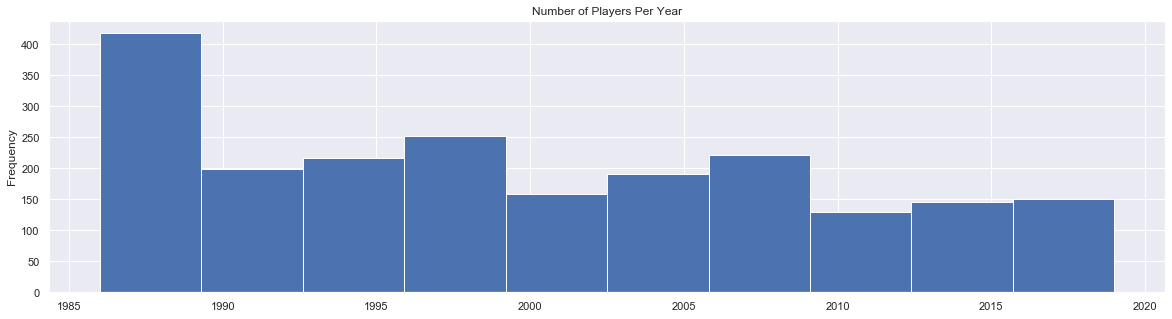

In [99]:
f, a = plt.subplots(1, 1, figsize=(20, 5))
players[players.pro_date > datetime.datetime(1985, 12, 31)].pro_date.dt.year.plot(kind='hist')
plt.title("Number of Players Per Year")

## Players Are Getting Older

Our data starts at 1985, we will look at 3 years: 1998, 2008, 2018 and look at the distribution of player ages for those years.

In 1998, you see that players are mostly 25 years or younger, with a steep decline in number of players older than 27. In 2008, you still see more younger players, and the same steep decline in players roughtly around 27 years old. However, in 2018, you see that player's age are spread over bigger age range and a slower decline for players 30 years or older.

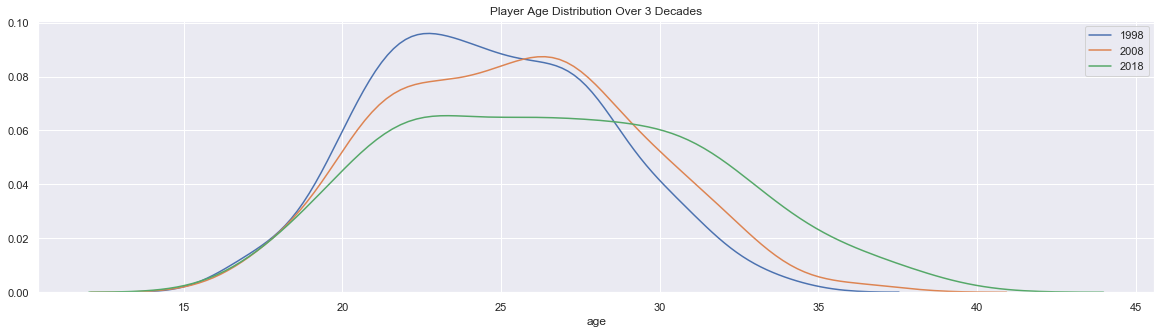

In [108]:
def get_players_for_year(year):
    pids = matches[(matches.tourney_date > datetime.datetime(year - 1, 12, 31)) &
                  (matches.tourney_date < datetime.datetime(year + 1, 1, 1))].loser_id.unique()
    pcopy = players[players.id.isin(pids)].copy()
    pcopy["age"] = pcopy.apply(lambda x: int((datetime.datetime(year, 12, 31) - x["birthday"]).days / 365), axis=1)
    return pcopy

f, a = plt.subplots(1, 1, figsize=(20, 5))
for year in [1998, 2008, 2018]:
    p = get_players_for_year(year)
    sns.distplot(p['age'], hist=False, label=year, bins=20, hist_kws={"alpha": .25})
    
plt.title("Player Age Distribution Over 3 Decades")
plt.legend()



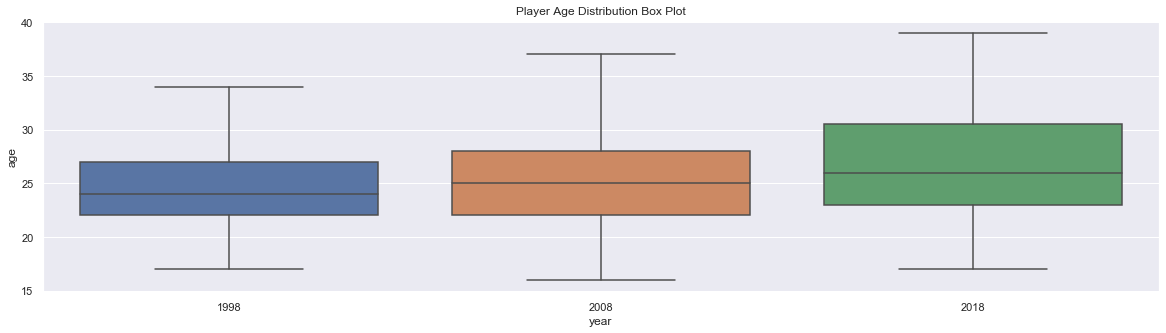

In [112]:
players1998 = get_players_for_year(1998)
players1998["year"] = 1998
players2008 = get_players_for_year(2008)
players2008["year"] = 2008
players2018 = get_players_for_year(2018)
players2018["year"] = 2018

p_boxplot = players1998.append(players2008, ignore_index=True)
p_boxplot = p_boxplot.append(players2018, ignore_index=True)

f, a = plt.subplots(1, 1, figsize=(20, 5))
sns.boxplot(x="year", y="age", data=p_boxplot)
_ = plt.title("Player Age Distribution Box Plot")

## How many matches do players generally play?

* 50% of all players have played more than 9 professional matches
* 75% of all places have players 73 matches or more

In [116]:
np.quantile(players.matches, [0.25, 0.5, 0.75])

array([ 2.,  9., 73.])

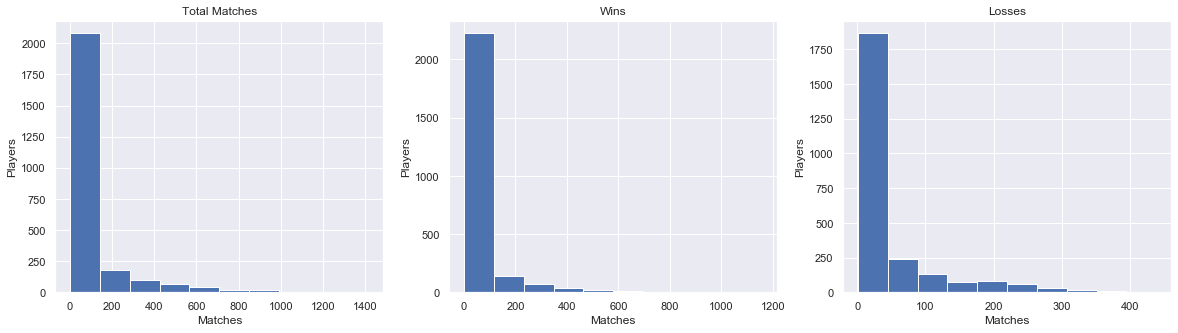

In [117]:
f, a = plt.subplots(1, 3, figsize=(20, 5))
players.matches.plot(kind='hist', ax=a[0], title="Total Matches")
a[0].set_xlabel("Matches")
a[0].set_ylabel("Players")
players.wins.plot(kind='hist', ax=a[1], title="Wins")
a[1].set_xlabel("Matches")
a[1].set_ylabel("Players")
players.losses.plot(kind='hist', ax=a[2], title="Losses")
a[2].set_xlabel("Matches")
_ = a[2].set_ylabel("Players")


Let's remove any players that played less than 100 matches

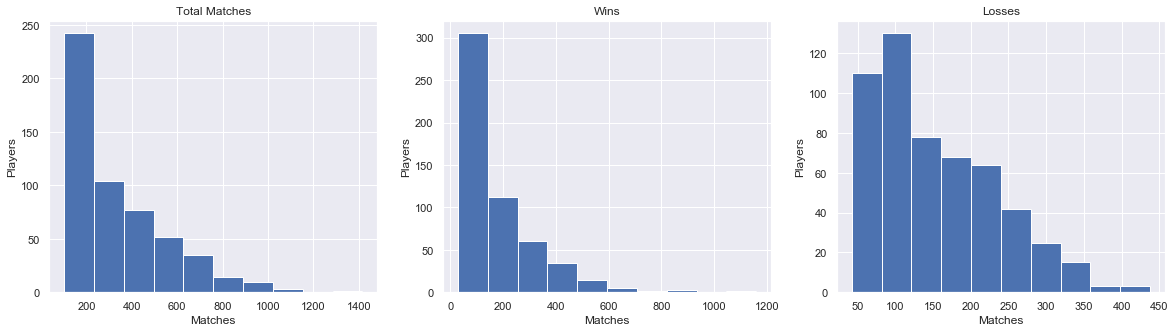

In [38]:
players100 = players[players.matches > 100]
f, a = plt.subplots(1, 3, figsize=(20, 5))
players100.matches.plot(kind='hist', ax=a[0], title="Total Matches")
a[0].set_xlabel("Matches")
a[0].set_ylabel("Players")
players100.wins.plot(kind='hist', ax=a[1], title="Wins")
a[1].set_xlabel("Matches")
a[1].set_ylabel("Players")
players100.losses.plot(kind='hist', ax=a[2], title="Losses")
a[2].set_xlabel("Matches")
_ = a[2].set_ylabel("Players")

## Players Are Getting Taller

Although average height for players remain roughly the same, you see in 2018 the 3rd quantile is higher meaning as well as the minimum height of players


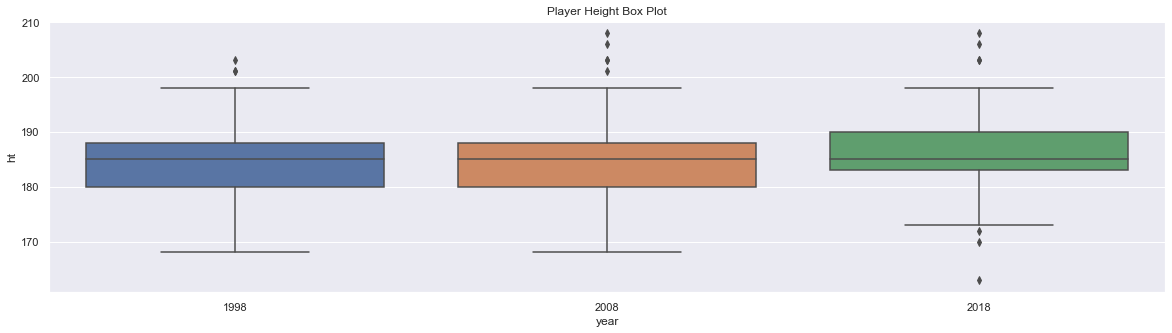

In [120]:
f, a = plt.subplots(1, 1, figsize=(20, 5))
sns.boxplot(x="year", y="ht", data=p_boxplot)
_ = plt.title("Player Height Box Plot")

## Let's look at tournament data

In [121]:
tourneys = matches.drop_duplicates(subset="tourney_id", keep='last')[["tourney_id", "tourney_name", "surface", "tourney_level", "tourney_date"]]
tourneys["year"] = tourneys.apply(lambda x: x["tourney_id"].split("-")[0], axis=1)
tourneys["id"] = tourneys.apply(lambda x: x["tourney_id"].split("-")[1], axis=1)
tourneys

,tourney_id,tourney_name,surface,tourney_level,tourney_date,year,id
30,1985-301,Auckland,Hard,A,1985-01-07,1985,301
41,1984-605,Masters,Carpet,M,1985-01-08,1984,605
104,1985-401,Philadelphia,Carpet,A,1985-01-21,1985,401
151,1985-402,Memphis,Carpet,A,1985-01-28,1985,402
278,1985-403,Delray Beach,Hard,M,1985-02-04,1985,403
...,...,...,...,...,...,...,...
113870,2019-0496,Marseille,Hard,A,2019-02-18,2019,0496
113901,2019-6932,Rio De Janeiro,Clay,A,2019-02-18,2019,6932
113932,2019-M004,Acapulco,Hard,A,2019-02-25,2019,M004
113963,2019-0495,Dubai,Hard,A,2019-02-25,2019,0495


### Looks like the number of tournaments has decreased a little bit since 1999 with 1994 having the most number of tour events. From 1999 to now, the number of tournaments per year has remain roughly the same.

Currently, the ATP website says there are 68 tournaments a year.

Text(0, 0.5, 'Tournaments')

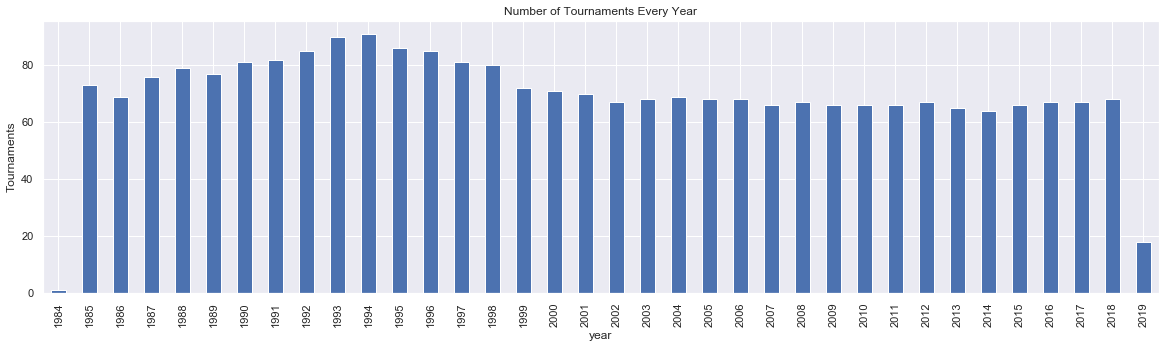

In [122]:
f, a = plt.subplots(1, 1, figsize=(20, 5))
tourneys.groupby("year").count()["tourney_id"].plot(kind='bar', title="Number of Tournaments Every Year")
a.set_ylabel("Tournaments")

## There are 218 unique tournaments in the dataset

I think tourney_id is a combination of year + unique identifier for tournaments - if take the content after '-' we should have a unique identifier for the tournament

Let's test this out

In [123]:
matches['tourney_id_no_year'] = matches.tourney_id.apply(lambda x: x.split("-")[1])

In [124]:
len(matches.tourney_id_no_year.unique())

218

Let's verify this to make sure they all have the same name

In [125]:
matches.tourney_id_no_year.sample(2).values

array(['421', '520'], dtype=object)

So, it looks like sometimes a tournament has the same ID but have different names - not sure why yet.

In [126]:
tids = matches.tourney_id_no_year.sample(40).values
matches[matches.tourney_id_no_year.isin(tids)][["tourney_name","tourney_id_no_year"]].drop_duplicates().sort_values("tourney_id_no_year")

,tourney_name,tourney_id_no_year
107270,Tokyo,0329
107546,Tour Finals,0605
64234,Madrid Masters,1536
0,Auckland,301
19372,Genova,306
34610,St. Poelten,306
85084,Kitzbuhel,306
75663,Poertschach,306
790,Bari,306
1390,Queen's Club,311


In [127]:
matches[matches.tourney_id_no_year == '433'][["tourney_name", "tourney_id_no_year", "tourney_id"]].drop_duplicates()

,tourney_name,tourney_id_no_year,tourney_id
6062,Scottsdale,433,1986-433
9603,Scottsdale,433,1987-433
13239,Scottsdale,433,1988-433
14437,Scottsdale,433,1989-433
25447,Scottsdale,433,1992-433
29273,Scottsdale,433,1993-433
33167,Scottsdale,433,1994-433
37121,Scottsdale,433,1995-433
40982,Scottsdale,433,1996-433
44692,Scottsdale,433,1997-433
